Importaciones

In [130]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import requests
from sklearn.dummy import DummyRegressor
from plotnine import *

API Token

In [131]:
api = "d073f379a0e94969beb4956bda52ef0f"
headers = {"X-Auth-Token": api}

Obtengo todos los datos

In [132]:
df = pd.DataFrame()
for year in range(2022, 2025):
    url = f'https://api.football-data.org/v4/competitions/PD/matches?season={year}'

    response = requests.get(url, headers=headers)
    data = response.json()

    matches = data["matches"]
    df_season = pd.DataFrame(matches)
    df = pd.concat([df, df_season], ignore_index=True)

Formateando columna 'season'

In [133]:
df['startDate'] = df['season'].apply(lambda x: x['startDate'])
df['endDate'] = df['season'].apply(lambda x: x['endDate'])

df['startDate'] = pd.to_datetime(df['startDate'])
df['endDate'] = pd.to_datetime(df['endDate'])
df['season'] = df['startDate'].dt.year.astype(str) + '/' + df['endDate'].dt.year.astype(str).str[-2:]

Formateando columnas 'awayTeam' y 'homeTeam'

In [134]:
df['homeTeam'] = df['homeTeam'].apply(lambda x: x['name'])
df['awayTeam'] = df['awayTeam'].apply(lambda x: x['name'])

Formateando columna 'score' y añadiendo columnas de goles de local y visitante, resultado media parte y resultado final

In [135]:
df['homeGoalsFullTime'] = df['score'].apply(lambda x: x['fullTime']).apply(lambda x: x["home"])
df['awayGoalsFullTime'] = df['score'].apply(lambda x: x['fullTime']).apply(lambda x: x["away"])

df['homeGoalsHalfTime'] = df['score'].apply(lambda x: x['halfTime']).apply(lambda x: x["home"])
df['awayGoalsHalfTime'] = df['score'].apply(lambda x: x['halfTime']).apply(lambda x: x["away"])

Formateando columna 'referees'

In [136]:
df["referees"] = df['referees'].apply(lambda x: x[0]['name'] if isinstance(x, list) and len(x) > 0 else None)

Eliminando columnas irrelevantes

In [137]:
df = df.drop(["startDate", "endDate", "competition", "area", "odds", "id", "utcDate", "stage", "group", "lastUpdated", "score"], axis=1)

Feature Engineering

In [138]:
teams = df["homeTeam"].unique()
seasons = df["season"].unique()

for team in teams:
    total_matches = df.loc[(df["awayTeam"] == team) | (df["homeTeam"] == team)]
    total_matches_finished = total_matches.loc[total_matches["status"] == "FINISHED"]
    total_matches_finished_len = len(total_matches_finished)
    total_away_team_goals = df.loc[(df["awayTeam"] == team)]["awayGoalsFullTime"].sum()
    total_home_team_goals = df.loc[(df["homeTeam"] == team)]["homeGoalsFullTime"].sum()
    total_goals = total_away_team_goals + total_home_team_goals
    df.loc[df["homeTeam"] == team, "totalHomeTeamGoals"] = total_goals
    df.loc[df["awayTeam"] == team, "totalAwayTeamGoals"] = total_goals
    df.loc[df["homeTeam"] == team, "homeTeamGoalRatio"] = total_goals / total_matches_finished_len
    df.loc[df["awayTeam"] == team, "awayTeamGoalRatio"] = total_goals / total_matches_finished_len
    df.loc[df["homeTeam"] == team, "totalHomeTeamGoalsAtHome"] = total_home_team_goals
    df.loc[df["awayTeam"] == team, "totalAwayTeamGoalsAway"] = total_away_team_goals
    df.loc[df["homeTeam"] == team, "homeTeamGoalRatioAtHome"] = total_home_team_goals / total_matches_finished_len
    df.loc[df["awayTeam"] == team, "awayTeamGoalRatioAway"] = total_away_team_goals / total_matches_finished_len
    total_home_team_goals_conceded = df.loc[df["homeTeam"] == team]["awayGoalsFullTime"].sum()
    total_away_team_goals_conceded = df.loc[df["awayTeam"] == team]["homeGoalsFullTime"].sum()
    total_goals_conceded = total_away_team_goals_conceded + total_home_team_goals_conceded
    df.loc[df["homeTeam"] == team, "totalHomeTeamGoalsConceded"] = total_goals_conceded
    df.loc[df["awayTeam"] == team, "totalAwayTeamGoalsConceded"] = total_goals_conceded
    df.loc[df["homeTeam"] == team, "homeTeamGoalConcededRatio"] = total_goals_conceded / total_matches_finished_len
    df.loc[df["awayTeam"] == team, "awayTeamGoalConcededRatio"] = total_goals_conceded / total_matches_finished_len
    df.loc[df["homeTeam"] == team, "totalHomeTeamGoalsConcededAtHome"] = total_home_team_goals_conceded
    df.loc[df["awayTeam"] == team, "totalAwayTeamGoalsConcededAway"] = total_away_team_goals_conceded
    df.loc[df["homeTeam"] == team, "homeTeamGoalConcededRatioAtHome"] = total_home_team_goals_conceded / total_matches_finished_len
    df.loc[df["awayTeam"] == team, "awayTeamGoalConcededRatioAway"] = total_away_team_goals_conceded / total_matches_finished_len

    for season in seasons:
        total_matches_finished_per_season = total_matches_finished.loc[total_matches_finished["season"] == season]
        total_matches_finished_per_season_len = len(total_matches_finished_per_season)
        total_home_team_goals_per_season = df.loc[(df["homeTeam"] == team) & (df["season"] == season)]["homeGoalsFullTime"].sum()
        total_away_team_goals_per_season = df.loc[(df["awayTeam"] == team) & (df["season"] == season)]["awayGoalsFullTime"].sum()
        total_home_team_goals_conceded_per_season = df.loc[(df["homeTeam"] == team) & (df["season"] == season)]["awayGoalsFullTime"].sum()
        total_away_team_goals_conceded_per_season = df.loc[(df["awayTeam"] == team) & (df["season"] == season)]["homeGoalsFullTime"].sum()
        total_goals_per_season = total_home_team_goals_per_season + total_away_team_goals_per_season
        total_goals_conceded_per_season = total_home_team_goals_conceded_per_season + total_away_team_goals_conceded_per_season
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "totalHomeTeamGoalsperSeason"] = total_goals_per_season
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "totalAwayTeamGoalsperSeason"] = total_goals_per_season
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "homeTeamGoalRatioperSeason"] = total_goals_per_season / total_matches_finished_per_season_len
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "awayTeamGoalRatioperSeason"] = total_goals_per_season / total_matches_finished_per_season_len
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "totalHomeTeamGoalsConcededperSeason"] = total_goals_conceded_per_season
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "totalAwayTeamGoalsConcededperSeason"] = total_goals_conceded_per_season
        df.loc[(df["homeTeam"] == team) & (df["season"] == season), "homeTeamGoalConcededRatioperSeason"] = total_goals_conceded_per_season / total_matches_finished_per_season_len
        df.loc[(df["awayTeam"] == team) & (df["season"] == season), "awayTeamGoalConcededRatioperSeason"] = total_goals_conceded_per_season / total_matches_finished_per_season_len





C:\Users\Edu\AppData\Local\Temp\ipykernel_13668\1258157430.py:42: RuntimeWarning: invalid value encountered in scalar divide
C:\Users\Edu\AppData\Local\Temp\ipykernel_13668\1258157430.py:43: RuntimeWarning: invalid value encountered in scalar divide
C:\Users\Edu\AppData\Local\Temp\ipykernel_13668\1258157430.py:46: RuntimeWarning: invalid value encountered in scalar divide
C:\Users\Edu\AppData\Local\Temp\ipykernel_13668\1258157430.py:47: RuntimeWarning: invalid value encountered in scalar divide


Preprocesando

In [139]:
df_train = df.loc[df["status"] == "FINISHED"]
df_test = df.loc[df["status"] != "FINISHED"]

In [140]:
df_train.columns

Index(['season', 'status', 'matchday', 'homeTeam', 'awayTeam', 'referees',
       'homeGoalsFullTime', 'awayGoalsFullTime', 'homeGoalsHalfTime',
       'awayGoalsHalfTime', 'totalHomeTeamGoals', 'totalAwayTeamGoals',
       'homeTeamGoalRatio', 'awayTeamGoalRatio', 'totalHomeTeamGoalsAtHome',
       'totalAwayTeamGoalsAway', 'homeTeamGoalRatioAtHome',
       'awayTeamGoalRatioAway', 'totalHomeTeamGoalsConceded',
       'totalAwayTeamGoalsConceded', 'homeTeamGoalConcededRatio',
       'awayTeamGoalConcededRatio', 'totalHomeTeamGoalsConcededAtHome',
       'totalAwayTeamGoalsConcededAway', 'homeTeamGoalConcededRatioAtHome',
       'awayTeamGoalConcededRatioAway', 'totalHomeTeamGoalsperSeason',
       'totalAwayTeamGoalsperSeason', 'homeTeamGoalRatioperSeason',
       'awayTeamGoalRatioperSeason', 'totalHomeTeamGoalsConcededperSeason',
       'totalAwayTeamGoalsConcededperSeason',
       'homeTeamGoalConcededRatioperSeason',
       'awayTeamGoalConcededRatioperSeason'],
      dtype='objec

EDA

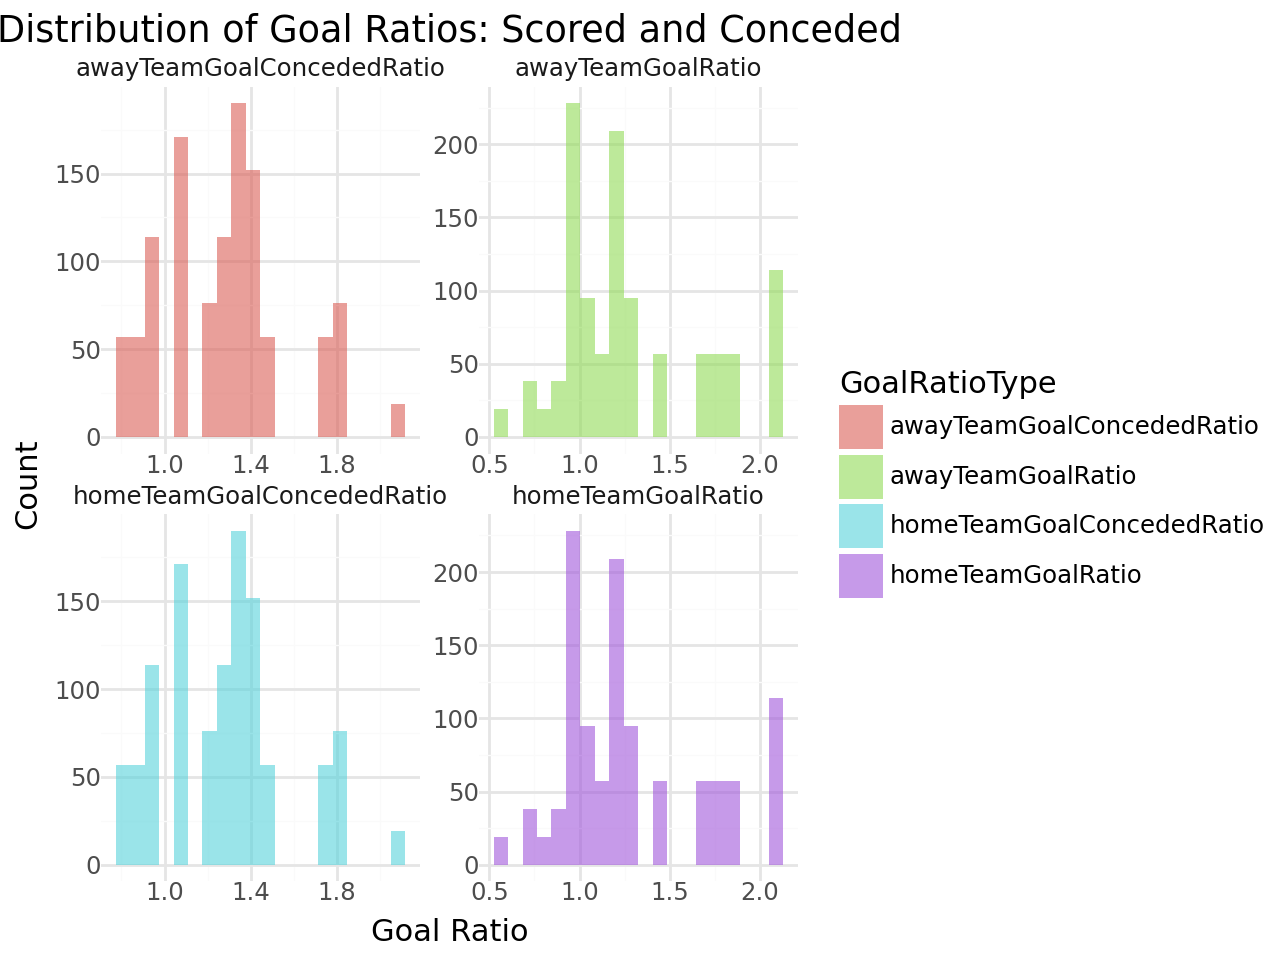

In [141]:
columns_to_plot = ['homeTeamGoalRatio', 'awayTeamGoalRatio', 'homeTeamGoalConcededRatio', 'awayTeamGoalConcededRatio']
df_melted = df.melt(value_vars=columns_to_plot, var_name='GoalRatioType', value_name='Ratio')
ggplot(df_melted, aes(x='Ratio', fill='GoalRatioType')) + geom_histogram(alpha=0.6, bins=20, position='identity') + facet_wrap('~GoalRatioType', scales='free') + labs(title='Distribution of Goal Ratios: Scored and Conceded', x='Goal Ratio', y='Count') + theme_minimal()


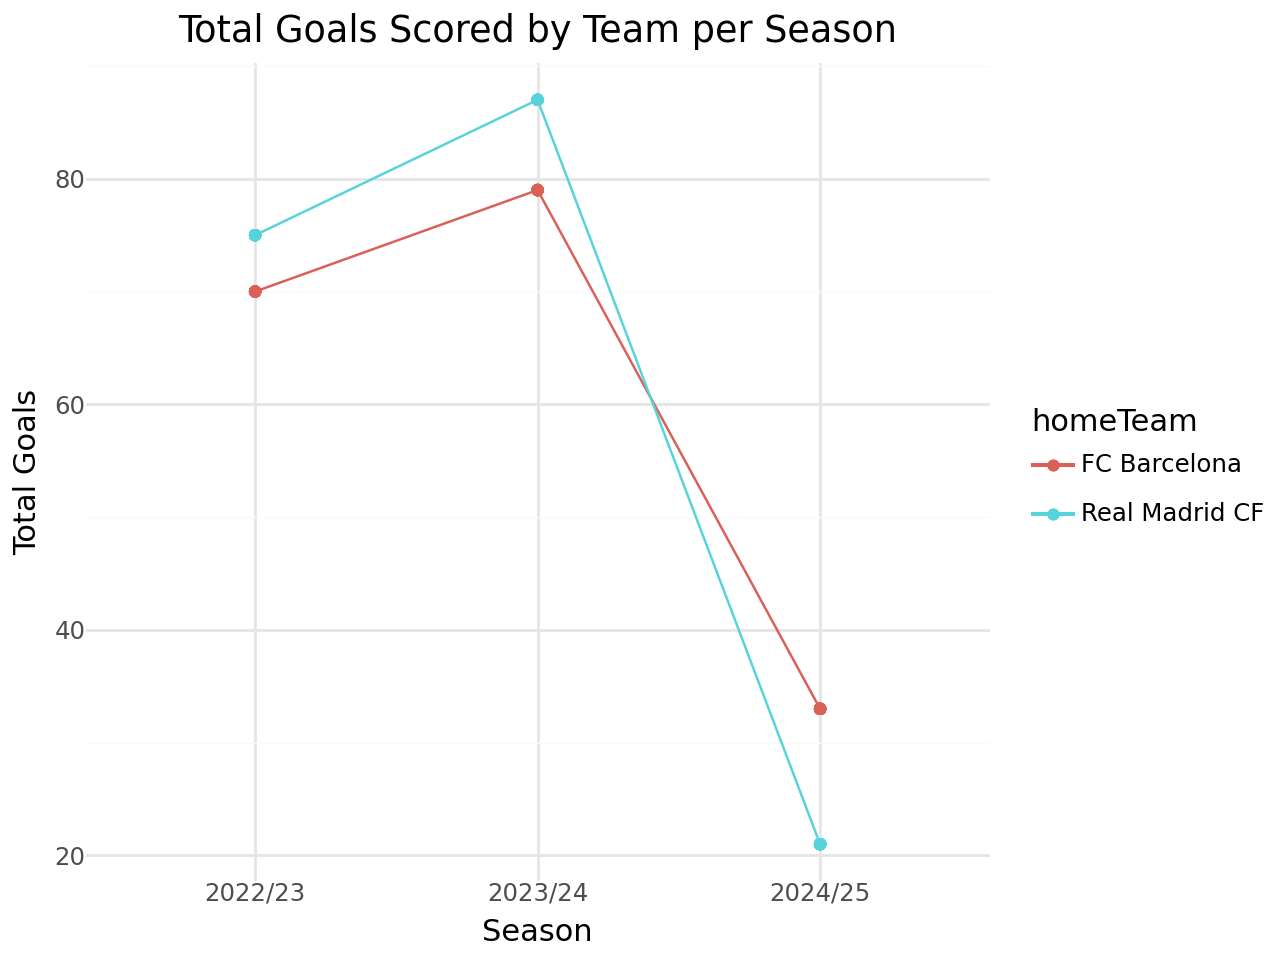

In [149]:
rm_fcb_comparison = df.loc[(df["homeTeam"] == "Real Madrid CF") | (df["homeTeam"] == "FC Barcelona")]
ggplot(rm_fcb_comparison, aes(x='season', y='totalHomeTeamGoalsperSeason', color='homeTeam', group='homeTeam')) + geom_point() + geom_line() + labs(title='Total Goals Scored by Team per Season', x='Season', y='Total Goals') + theme_minimal()